# Assignment 4: Data Collection & Analysis (Korean University Lecture Data)

## 사전 데이터 준비 요약 (이미 실행 완료)
이 Notebook에서 사용하는 `comp_sentences.csv`는 AI Hub "한국어 대학 강의 데이터" 라벨링 파일(TL.zip)에서  
**컴퓨터통신(eng/comp)** 카테고리만 추출하여 문장 단위 CSV로 변환해 둔 결과입니다.

사전 준비 과정은 아래와 같습니다.

1. TL.zip.part0 / TL.zip.part1 병합 → TL.zip 생성
2. TL.zip 내부에서 `eng/comp/` 경로만 선택적으로 추출 → `TL_comp/`
3. `TL_comp/`의 json을 파싱하여  
   (lecture_id, major, sentence) 형태로 CSV 생성 → `comp_sentences.csv`

따라서 본 Notebook에서는 **CSV 로드 및 EDA(탐색적 분석)** 부터 시작합니다.

### 셀 1 — **드라이브 마운트 & 작업 폴더 이동**

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

%cd /content/drive/MyDrive/ML_Project
!ls -al

Mounted at /content/drive
/content/drive/MyDrive/ML_Project
total 2415589
-rw------- 1 root root   14931818 Nov 24 09:08 comp_sentences.csv
drwx------ 2 root root       4096 Nov 24 07:52 TL_comp
-rw------- 1 root root 1229313082 Nov 24 05:58 TL.zip
-rw------- 1 root root 1073741824 Nov 22 16:34 TL.zip.part0
-rw------- 1 root root  155571258 Nov 22 16:36 TL.zip.part1


### 셀 2 — **라이브러리 import**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re

### 셀 3 — **데이터 로드**

In [3]:
df = pd.read_csv("comp_sentences.csv")
df.head()

,lecture_id,major,sentence
0,C02199,comp,자연 (log)/(로그)를 취한 겁니다.
1,C02199,comp,이렇게 하면 이렇게 된다.
2,C02199,comp,1 0 1 1 0 이렇게 되니까 되니까 띠 모양 있는 부분만 남기고 다 죽이는 모든...
3,C02199,comp,통과시키는 걸 볼 수 있겠죠?
4,C02199,comp,이제 구성은 이렇게 되어 있고요.


### 셀 4 — 데이터 기본 정보

In [4]:
print("데이터 크기:", df.shape)
print("\n컬럼:")
print(df.columns)

df.info()

데이터 크기: (122144, 3)

컬럼:
Index(['lecture_id', 'major', 'sentence'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122144 entries, 0 to 122143
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   lecture_id  122144 non-null  object
 1   major       122144 non-null  object
 2   sentence    122144 non-null  object
dtypes: object(3)
memory usage: 2.8+ MB


### 셀 5 — 결측치 / 중복 확인

In [5]:
print("결측치 개수:")
print(df.isna().sum())

print("\n중복 행 개수:", df.duplicated().sum())

결측치 개수:
lecture_id    0
major         0
sentence      0
dtype: int64

중복 행 개수: 2909


### 셀 6 — 문장 길이(문자 수) 통계

In [6]:
df["sent_len"] = df["sentence"].astype(str).apply(len)

df["sent_len"].describe()

,sent_len
count,122144.000000
mean,46.917696
std,39.882380
min,1.000000
25%,20.000000
50%,36.000000
75%,62.000000
max,567.000000


### 셀 7 — 문장 길이 분포 시각화

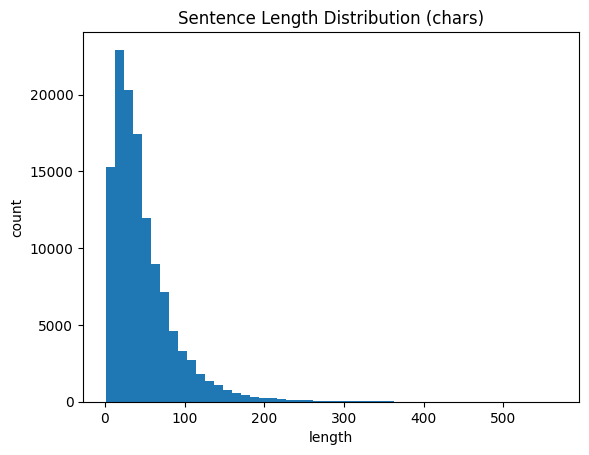

In [7]:
plt.figure()
plt.hist(df["sent_len"], bins=50)
plt.title("Sentence Length Distribution (chars)")
plt.xlabel("length")
plt.ylabel("count")
plt.show()

### 셀 8 — 강의(lecture_id) 단위 통계

In [8]:
n_lectures = df["lecture_id"].nunique()
print("강의(lecture_id) 개수:", n_lectures)

lecture_counts = df["lecture_id"].value_counts()
lecture_counts.head(10)


강의(lecture_id) 개수: 367


,count
lecture_id,
C02831,1433
C17831,1433
C02522,1312
C02224,1040
C02670,1001
C02977,989
C06502,899
C03088,873
C13604,864


### 셀 9 — 가장 자주 등장하는 단어 Top20

In [9]:
def tokenize(s):
    return re.findall(r"[가-힣A-Za-z0-9]+", s)

words = []
for s in df["sentence"]:
    words += tokenize(str(s))

Counter(words).most_common(20)

[('이', 19574),
 ('그래서', 15183),
 ('이제', 14305),
 ('어', 13986),
 ('자', 12975),
 ('이렇게', 12867),
 ('그', 12844),
 ('우리가', 11534),
 ('수', 10540),
 ('이런', 10205),
 ('있는', 9668),
 ('뭐', 9353),
 ('하는', 5731),
 ('때', 5726),
 ('지금', 5606),
 ('그리고', 5503),
 ('있습니다', 5445),
 ('요', 5327),
 ('그러면', 5249),
 ('어떤', 4876)]